# Name : Shadeeb Hossain
# Id: sh7492


# Multiple Linear Regression for Robot Calibration

In this lab, we will illustrate the use of multiple linear regression for calibrating robot control.  In addition to reviewing the concepts in the [multiple linear regression demo](https://github.com/pliugithub/MachineLearning/blob/master/unit03_mult_lin_reg/demo1_glucose.ipynb), you will see how to use multiple linear regression for time series data -- an important concept in dynamical systems such as robotics.

The robot data for the lab is taken generously from the TU Dortmund's [Multiple Link Robot Arms Project](https://rst.etit.tu-dortmund.de/forschung/robotik/leichtbau/details-tudor/).  As part of the project, they have created an excellent public dataset: [MERIt](https://rst.etit.tu-dortmund.de/forschung/robotik/leichtbau/details-tudor/#c11560) -- A Multi-Elastic-Link Robot Identification Dataset that can be used for understanding robot dynamics.  The data is from a three link robot:

<img src="https://rst.etit.tu-dortmund.de/storages/rst-etit/r/Media_Forschung/Robotik/Leichtbau/TUDORBild.png" height="200" width="200">


We will focus on predicting the current draw into one of the joints as a function of the robot motion.  Such models are essential in predicting the overall robot power consumption.  Several other models could also be used.

## Load and Visualize the Data
First, import the modules we will need.

In [14]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

The full MERIt dataset can be obtained from the [MERIt site](http://www.rst.e-technik.tu-dortmund.de/cms/en/research/robotics/TUDOR_engl/index.html#h3MERIt).  But, this dataset is large.  Included in this repository are two of the ten experiments.  Each experiments corresonds to 80 seconds of recorded motion.  We will use the following files:
* [exp1.csv](./exp1.csv) for training
* [exp2.csv](./exp2.csv) for test

If you are running this notebook on Google colab, you will need to run the following commands to load the files onto your local machine.  Otherwise, if you have clone the repository, the files should be in the directory as the notebook and you can skip this step.

In [15]:
import os
from six.moves import urllib

for fn_dst in ['exp1.csv', 'exp2.csv']:
    fn_src = 'https://raw.githubusercontent.com/sdrangan/introml/master/unit03_mult_lin_reg/%s' % fn_dst

    if os.path.isfile(fn_dst):
        print('File %s is already downloaded' % fn_dst)
    else:
        print('Downloaded %s' % fn_dst)
        urllib.request.urlretrieve(fn_src, fn_dst)

File exp1.csv is already downloaded
File exp2.csv is already downloaded


Below, I have supplied the column headers in the `names` array.  Use the `pd.read_csv` command to load the training data in `exp1.csv`.  Use the `index_col` option to specify that column 0 (the one with time) is the *index* column.  You can review [simple linear regression demo](https://github.com/pliugithub/MachineLearning/blob/master/unit02_simp_lin_reg/demo_auto_mpg.ipynb) for examples of using the `pd.read_csv` command.

In [16]:
names =['t',                                 # Time (secs)
    'q1', 'q2', 'q3',                     # Joint angle   (rads)
    'dq1', 'dq2', 'dq3',                  # Joint velocity (rads/sec)
    'I1', 'I2', 'I3',                     # Motor current (A)
    'eps21', 'eps22', 'eps31', 'eps32',   # Strain gauge measurements ($\mu$m /m )
    'ddq1', 'ddq2', 'ddq3'                # Joint accelerations (rad/sec^2)
]
# TODO 1
df=pd.read_csv('exp1.csv',header=None,delim_whitespace=False, names=names, na_values='?')

Print the first six lines of the pandas dataframe and manually check that they match the first rows of the csv file.

In [17]:
# TODO 2
df.head(6)

,t,q1,q2,q3,dq1,dq2,dq3,I1,I2,I3,eps21,eps22,eps31,eps32,ddq1,ddq2,ddq3
0,0.00,-0.000007,2.4958,-1.1345,-7.882100e-21,-4.940656e-321,3.913100e-29,-0.081623,-0.40812,-0.30609,-269.25,-113.20,3.5918,1.57860,-9.904900e-19,-6.210306e-319,4.917400e-27
1,0.01,-0.000007,2.4958,-1.1345,-2.258200e-21,-4.940656e-321,2.626200e-31,-0.037411,-0.37241,-0.26698,-270.91,-116.05,1.4585,-1.73980,4.248100e-19,-1.766878e-319,-1.381100e-27
2,0.02,-0.000007,2.4958,-1.1345,-6.469800e-22,-4.940656e-321,1.762500e-33,-0.066319,-0.40302,-0.31459,-269.25,-112.97,3.5918,0.86753,3.233800e-19,-4.990557e-320,-4.117300e-28
3,0.03,-0.000007,2.4958,-1.1345,-1.853600e-22,-4.940656e-321,1.182800e-35,-0.068020,-0.43703,-0.28398,-269.97,-114.39,1.6956,-0.08059,1.500500e-19,-1.394253e-320,-1.173100e-28
4,0.04,-0.000007,2.4958,-1.1345,-5.310600e-23,-4.940656e-321,-5.270900e-03,-0.052715,-0.40472,-0.30779,-269.97,-114.15,3.1177,0.86753,5.932400e-20,-3.581976e-321,-3.770800e-01
5,0.05,-0.000007,2.4958,-1.1345,-1.521500e-23,-4.940656e-321,3.252600e-04,-0.088425,-0.42342,-0.29589,-269.25,-114.15,2.4066,-0.08059,2.164600e-20,-1.141292e-321,2.930300e-01


From the dataframe `df`, extract the time indices into a vector `t` and extract `I2`, the current into the second joint.  Place the current in a vector `y` and plot `y` vs. `t`.   Label the axes with the units.

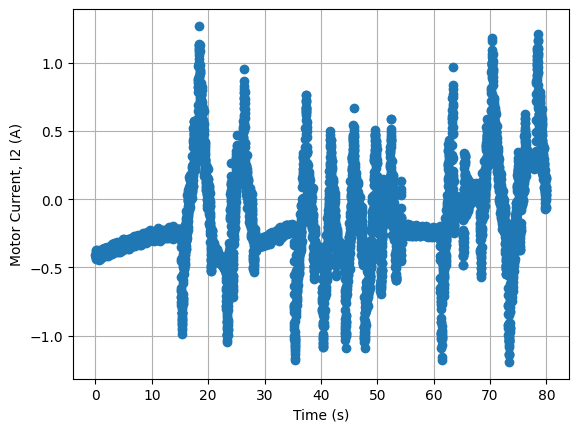

In [18]:
# TODO 3
t=np.array(df['t'])
y=np.array(df['I2'])
plt.plot(t,y,'o')
plt.xlabel('Time (s)')
plt.ylabel('Motor Current, I2 (A)')
plt.grid(True)

Use all the samples from the experiment 1 dataset to create the training data:
* `ytrain`:  A vector of all the samples from the `I2` column
* `Xtrain`:  A matrix of the data with the columns:  `['q2','dq2','eps21', 'eps22', 'eps31', 'eps32','ddq2']`

In [19]:
# TODO 4
from types import new_class
ns_train=len(y)
ytrain = y[:ns_train]
print("The vector of all the samples from the I2 column: ", ytrain)
Xtrain=df[['q2','dq2','eps21','eps22','eps31','eps32','ddq2']].values   # reference site: https://euanrussano.github.io/20190810linearRegressionNumpy/
print("The matrix of all the data with the columns: ", Xtrain)


The vector of all the samples from the I2 column:  [-0.40812  -0.37241  -0.40302  ...  0.06802   0.011903  0.037411]
The matrix of all the data with the columns:  [[ 2.4958e+000 -4.9407e-321 -2.6925e+002 ...  3.5918e+000  1.5786e+000
  -6.2103e-319]
 [ 2.4958e+000 -4.9407e-321 -2.7091e+002 ...  1.4585e+000 -1.7398e+000
  -1.7669e-319]
 [ 2.4958e+000 -4.9407e-321 -2.6925e+002 ...  3.5918e+000  8.6753e-001
  -4.9906e-320]
 ...
 [ 1.9659e+000  1.0957e+000 -1.1803e+002 ... -2.0969e+000  3.7119e+000
   8.2264e-001]
 [ 1.9768e+000  1.0913e+000 -1.3320e+002 ... -1.2526e+001 -5.7693e+000
  -8.2050e-002]
 [ 1.9877e+000  1.0899e+000 -1.3557e+002 ... -1.1104e+001 -1.5028e+000
  -1.2559e-001]]


## Fit a Linear Model
Use the `sklearn.linear_model` module to create a `LinearRegression` class `regr`.

In [20]:
from sklearn import linear_model

# Create linear regression object
# TODO 5
regr=linear_model.LinearRegression()
regr.fit(Xtrain,ytrain)

LinearRegression()

Train the model on the training data.

In [21]:
# TODO 6
regr.intercept_

-0.08408083770448144

In [22]:
regr.coef_

array([ 0.06255018,  0.20584896,  0.00118784,  0.00044457, -0.0031362 ,
        0.00603298,  0.05487097])

Using the trained model, compute, `ytrain_pred`, the predicted current.  Plot `ytrain_pred` vs. time `t`.  On the same plot, plot the actual current `ytrain` vs. time `t`.  Create a legend for the plot.

RSS per sample=0.095833
R^2=  0.904167


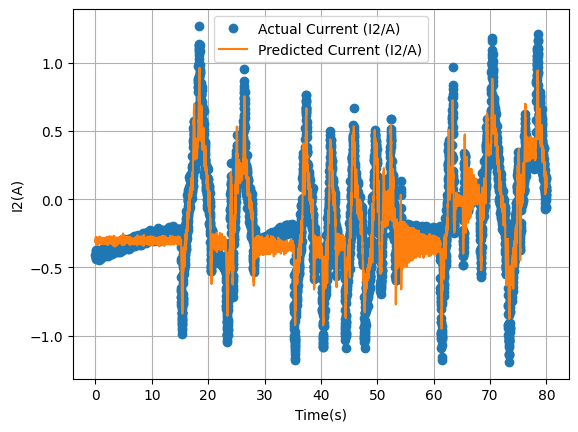

In [23]:
# TODO 7
ytrain_pred =regr.predict(Xtrain)
RSS_tr=np.mean((ytrain_pred-ytrain)**2)/(np.std(ytrain)**2)
Rsq_tr=1-RSS_tr
print("RSS per sample={0:f}".format(RSS_tr))
print("R^2=  {0:f}".format(Rsq_tr))
plt.plot(t,ytrain,'o')
plt.plot(t,ytrain_pred,'-')
plt.ylabel('I2(A)')
plt.xlabel('Time(s)')
plt.grid()
plt.legend(['Actual Current (I2/A)','Predicted Current (I2/A)'])

Measure the normalized RSS given by $RSS / (n s^2_y)$.

In [24]:
# TODO 8
ytrain_pred=regr.predict(Xtrain)
RSS_tr=np.mean((ytrain_pred-ytrain)**2)/(np.std(ytrain)**2)
Rsq_tr=1-RSS_tr
print("RSS per sample={0:f}".format(RSS_tr))
print("R^2= {0:f}".format(Rsq_tr))


RSS per sample=0.095833
R^2= 0.904167


## Measure the Fit on an Indepdent Dataset

Up to now, we have only tested the model on the same data on which it was trained.  In general, we need to test model on independent data not used in the training.  For this purpose, load the data in `exp2.csv`.  Compute the regression predicted values on this data and plot the predicted and actual values over time.

In [25]:
# TODO 9
df2=pd.read_csv('exp2.csv',header=None,delim_whitespace=False,names=names,na_values='?')
df2.head(6)

,t,q1,q2,q3,dq1,dq2,dq3,I1,I2,I3,eps21,eps22,eps31,eps32,ddq1,ddq2,ddq3
0,0.00,-0.000007,1.9024,0.26063,-0.000364,4.940656e-321,0.012596,-0.096928,-0.15134,-0.017005,-130.83,-41.856,-6.3635,5.13410,-0.045712,6.210306e-319,1.582900
1,0.01,0.000013,1.9024,0.26073,0.000739,4.940656e-321,0.012095,-0.028908,-0.11903,-0.020406,-138.18,-51.100,-14.6590,-5.05820,0.125580,1.766878e-319,0.414660
2,0.02,-0.000007,1.9024,0.26086,-0.000580,4.940656e-321,0.011596,-0.059517,-0.13944,-0.047614,-139.36,-51.812,-14.6590,-5.29520,-0.130080,4.990557e-320,0.082286
3,0.03,0.000013,1.9024,0.26099,0.001409,4.940656e-321,0.013933,-0.079923,-0.15304,-0.023807,-135.57,-48.019,-11.3410,-0.79168,0.213010,1.394253e-320,0.190650
4,0.04,-0.000007,1.9024,0.26110,-0.001273,4.940656e-321,0.010793,-0.025507,-0.12924,-0.006802,-135.81,-49.204,-12.0520,-2.21390,-0.276490,3.581976e-321,-0.170400
5,0.05,-0.000007,1.9024,0.26124,0.001928,4.940656e-321,0.011915,-0.083324,-0.14964,-0.034010,-139.60,-53.471,-16.0820,-6.95450,0.323560,1.141292e-321,0.031745


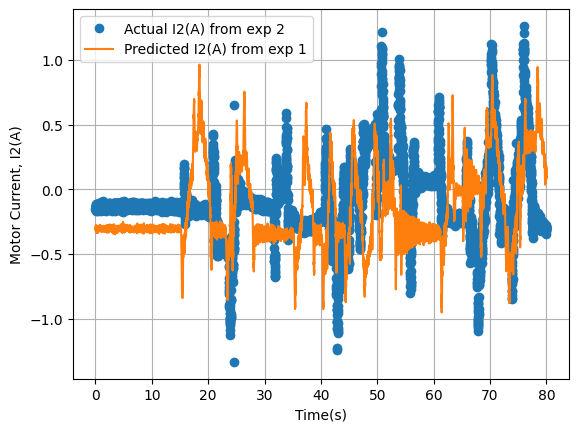

In [31]:
t1=np.array(df2['t'])
y1=np.array(df2['I2'])
plt.plot(t1,y1,'o')
plt.plot(t,ytrain_pred,'-')
plt.xlabel('Time(s)')
plt.ylabel('Motor Current, I2(A)')
plt.grid(True)
plt.legend(['Actual I2(A) from exp 2','Predicted I2(A) from exp 1'])

Measure the normalized RSS on the test data.

In [32]:
# TODO 10
RSS_test = np.mean((ytrain_pred-y1)**2)/(np.std(y1)**2)
Rsq_tr_1=1-RSS_test
print("RSS per sample={0:f}".format(RSS_test))
print("R^2= {0:f}".format(Rsq_tr_1))

RSS per sample=2.065983
R^2= -1.065983


In [26]:
# The RSS ( Residual Sum of Squares) calculates the degree of variance in a regression model.
# It estimates the level of error in the model's prediction.
# The smaller the residual sum of squares (RSS) the better the model fits the data, the larger the RSS the worse it is.

# From the above model it is realized that even though the RSS was significantly better when used for predicting the trained data in Exp 1
# but the RSS and R^2 increased when applied the Multiple Linear Regression model to data in Experiment 2